In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Embedding, Dropout,BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('all-data.csv', delimiter=',', encoding='latin-1', names=['sentiment', 'text'])
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
class_distribution = df['sentiment'].value_counts(normalize=True)
class_distribution

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

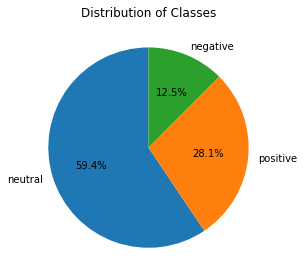

In [ ]:
labels = class_distribution.index
values = class_distribution.values
plt.pie(values, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.tight_layout()
plt.show()

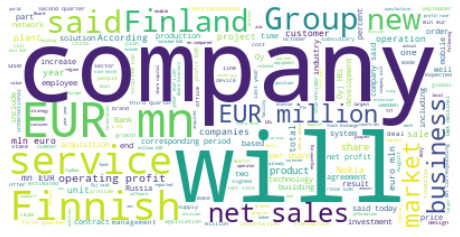

In [ ]:
text = " ".join([x for x in df.text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Data preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Remove punctuation


In [ ]:
def rem_punc(t):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''

    # remove punctuation from the string
    for c in punctuations:
        t=t.replace(c,' ')

    # display the unpunctuated string
    return t.replace('\n',' ')

df['punct'] = df['text'].apply(lambda x: rem_punc(x))

Lowercase

In [ ]:
df['lowercase'] = df['punct'].apply(lambda x: x.lower())

Tokenization

In [ ]:
df['tokenized'] = df['lowercase'].apply(lambda x: word_tokenize(x))

Remove stopwords

In [ ]:
sw = stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in sw]
    return text
df['nonsw'] = df['tokenized'].apply(lambda x: remove_stopwords(x))

Lemmatization

In [ ]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(t):
    nltk_tagged = nltk.pos_tag(t)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemma = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemma.append(word)
        else:        
            lemma.append(lemmatizer.lemmatize(word, tag))
    return lemma

df['lemmed'] = df['nonsw'].apply(lambda x: lemmatize_sentence(x))

In [ ]:
df.head()

,sentiment,text,punct,lowercase,tokenized,nonsw,lemmed
0,neutral,"According to Gran , the company has no plans t...",According to Gran the company has no plans t...,according to gran the company has no plans t...,"[according, to, gran, the, company, has, no, p...","[according, gran, company, plans, move, produc...","[accord, gran, company, plan, move, production..."
1,neutral,Technopolis plans to develop in stages an area...,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le...","[technopolis, plan, develop, stage, area, less..."
2,negative,The international electronic industry company ...,The international electronic industry company ...,the international electronic industry company ...,"[the, international, electronic, industry, com...","[international, electronic, industry, company,...","[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,With the new production plant the company woul...,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre...","[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,According to the company s updated strategy f...,according to the company s updated strategy f...,"[according, to, the, company, s, updated, stra...","[according, company, updated, strategy, years,...","[accord, company, update, strategy, year, basw..."


##Word embeddings Word2vec


In [ ]:
data=df['lemmed']
model_w2v = Word2Vec(
            data,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(data, total_examples= len(df['lemmed']), epochs=20)

(1004943, 1196920)

In [ ]:
model_w2v.wv.most_similar(positive="business")

[('frozen', 0.5053852796554565),
 ('apetit', 0.49939218163490295),
 ('foodservice', 0.4912070631980896),
 ('rigid', 0.48503634333610535),
 ('qt', 0.47283458709716797),
 ('homeowner', 0.47277599573135376),
 ('eaton', 0.46965283155441284),
 ('kalmar', 0.46706438064575195),
 ('clarify', 0.46663597226142883),
 ('skogster', 0.4570878744125366)]

In [ ]:
X=df.lemmed
Y=df.sentiment

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
encoded_docs = tokenizer.texts_to_sequences(X)
max_length = max([len(s) for s in X])
x = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
# Transform categories into numbers
le = LabelEncoder()
y = le.fit_transform(Y)
y = to_categorical(y)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for word, i in tokenizer.word_index.items():
  if word in model_w2v.wv.vocab.keys():
    embedding_matrix[i] = model_w2v.wv[word]

## CNN

In [ ]:
# splitting data
x_train,x_test,y_train,y_test = train_test_split(x, y,test_size = 0.2 , random_state = 0)

In [ ]:
def cnn(x_train,x_test,y_train,y_test):
  model = Sequential()
  model.add(Embedding(len(tokenizer.word_index)+1, 200, input_length=x.shape[1], weights=[embedding_matrix]))
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  print(model.summary())

  early_stopping = EarlyStopping(
      monitor='loss',
      patience=3,
      verbose=1,
      restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(
      monitor='loss',
      factor=0.5,
      patience=1,
      verbose=1)

  callbacks = [ reduce_lr, early_stopping]
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(x_train, y_train, epochs=10, verbose=2, callbacks=callbacks)

  y_predict=model.predict(x_test)
  y_predict=np.argmax(y_predict, axis=1)
  y_test=np.argmax(y_test, axis=1)
  print(classification_report(y_test, y_predict))


In [ ]:
cnn(x_train,x_test,y_train,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 200)           1505600   
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6915      
Total params: 1,640,643
Trainable params: 1,640,643
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
122/122 - 23s - loss: 0.4839 - accuracy: 0.6473
Epoch 2/10
122/122 - 6s - loss: 0.3624 - accurac

## Handling data imbalance

#### Take into account class imbalances during the split stratifying the data according to y labels

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, test_size = 0.2 , random_state = 0)

In [ ]:
cnn(xtrain, xtest, ytrain, ytest)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           1505600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 128)           128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6915      
Total params: 1,640,643
Trainable params: 1,640,643
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
122/122 - 8s - loss: 0.4937 - accuracy: 0.6483
Epoch 2/10
122/122 - 6s - loss: 0.3637 - accura

#### Reduce the number of samples in the prevailing category to make it proportional to the least represented group

In [ ]:
n = df['sentiment'].value_counts().min()
n

604

In [ ]:
balanced_data = pd.DataFrame(columns=['sentiment', 'lemmed'])
# Reduce each group to the chosen number of samples
data_groups = df.groupby('sentiment')
for group in data_groups.indices:
    reduced_class = data_groups.get_group(group)[['sentiment', 'lemmed']].iloc[:n, :]
    balanced_data = balanced_data.append(reduced_class, ignore_index=True)

In [ ]:
# Class distribution in the new dataset
balanced_data['sentiment'].value_counts()

neutral     604
negative    604
positive    604
Name: sentiment, dtype: int64

In [ ]:
x2=balanced_data.lemmed
y2 = to_categorical(le.fit_transform(balanced_data['sentiment']))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x2)
encoded_docs = tokenizer.texts_to_sequences(x2)
max_length = max([len(s) for s in x2])
x2 = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for word, i in tokenizer.word_index.items():
  if word in model_w2v.wv.vocab.keys():
    embedding_matrix[i] = model_w2v.wv[word]

In [ ]:
# Training and test samples
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,
                                                    y2,
                                                    stratify=y2,
                                                    test_size=0.2,
                                                    random_state=1)


In [ ]:
early_stopping = EarlyStopping(
      monitor='loss',
      patience=3,
      verbose=1,
      restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
      monitor='loss',
      factor=0.5,
      patience=1,
      verbose=1)

callbacks = [ reduce_lr, early_stopping]

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 200, input_length=x2.shape[1], weights=[embedding_matrix]))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           800000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 128)           128128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 934,275
Trainable params: 934,275
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(x2_train, y2_train, epochs=10, verbose=2, callbacks=callbacks)

Epoch 1/10
46/46 - 3s - loss: 0.5668 - accuracy: 0.5010
Epoch 2/10
46/46 - 2s - loss: 0.4350 - accuracy: 0.7053
Epoch 3/10
46/46 - 2s - loss: 0.3112 - accuracy: 0.8240
Epoch 4/10
46/46 - 2s - loss: 0.2002 - accuracy: 0.9110
Epoch 5/10
46/46 - 2s - loss: 0.1190 - accuracy: 0.9600
Epoch 6/10
46/46 - 2s - loss: 0.0773 - accuracy: 0.9738
Epoch 7/10
46/46 - 2s - loss: 0.0563 - accuracy: 0.9827
Epoch 8/10
46/46 - 2s - loss: 0.0433 - accuracy: 0.9834
Epoch 9/10
46/46 - 2s - loss: 0.0312 - accuracy: 0.9869
Epoch 10/10
46/46 - 2s - loss: 0.0335 - accuracy: 0.9848

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


In [ ]:
y2_predict=model.predict(x2_test)
y2_predict=np.argmax(y2_predict, axis=1)
y2_test=np.argmax(y2_test, axis=1)
print(classification_report(y2_test, y2_predict))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       121
           1       0.68      0.79      0.73       121
           2       0.70      0.67      0.68       121

    accuracy                           0.72       363
   macro avg       0.72      0.72      0.72       363
weighted avg       0.72      0.72      0.72       363



#### Oversampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
cnn(x_train_res, x_test, y_train_res, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 200)           1505600   
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6915      
Total params: 1,640,643
Trainable params: 1,640,643
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
216/216 - 27s - loss: 0.5734 - accuracy: 0.5006
Epoch 2/10
216/216 - 11s - loss: 0.4412 - accura

## LSTM

In [ ]:
# init layer
model_lstm = Sequential()

# emmbed word vectors
model_lstm .add(Embedding(len(tokenizer.word_index)+1, 200, input_length=x.shape[1], weights=[embedding_matrix]))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model_lstm .add(LSTM(50,return_sequences=False))
model_lstm .add(Dense(3,activation="softmax"))

# output model skeleton
model_lstm .summary()
model_lstm .compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           1505600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 1,555,953
Trainable params: 1,555,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# splitting data
x_train,x_test,y_train,y_test = train_test_split(x, y, stratify=y, test_size = 0.2 , random_state = 0)

In [ ]:
model_lstm.fit(x_train, y_train, epochs=10, verbose=2)

Epoch 1/10
122/122 - 22s - loss: 0.5297 - acc: 0.6138
Epoch 2/10
122/122 - 5s - loss: 0.4344 - acc: 0.6868
Epoch 3/10
122/122 - 5s - loss: 0.3494 - acc: 0.7554
Epoch 4/10
122/122 - 5s - loss: 0.2986 - acc: 0.7902
Epoch 5/10
122/122 - 5s - loss: 0.2596 - acc: 0.8117
Epoch 6/10
122/122 - 5s - loss: 0.2513 - acc: 0.8145
Epoch 7/10
122/122 - 5s - loss: 0.2083 - acc: 0.8633
Epoch 8/10
122/122 - 5s - loss: 0.1725 - acc: 0.9040
Epoch 9/10
122/122 - 5s - loss: 0.1799 - acc: 0.9014
Epoch 10/10
122/122 - 5s - loss: 0.1511 - acc: 0.9211


In [ ]:
loss, acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 72.061855


In [ ]:
y_predict=model_lstm.predict(x_test)
y_predict=np.argmax(y_predict, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55       128
           1       0.82      0.81      0.81       575
           2       0.56      0.64      0.60       267

    accuracy                           0.72       970
   macro avg       0.67      0.65      0.66       970
weighted avg       0.73      0.72      0.72       970

